<a href="https://colab.research.google.com/github/NariMo91/GANs-generative-art/blob/main/latent_space_malliGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Latent Space Exploration

In [ ]:
# Mount G-Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Clone StyleGAN2 ADA PyTorch from GitHub.

In [ ]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 125, done.
remote: Total 125 (delta 0), reused 0 (delta 0), pack-reused 125
Receiving objects: 100% (125/125), 1.12 MiB | 3.36 MiB/s, done.
Resolving deltas: 100% (55/55), done.
     |████████████████████████████████| 108 kB 8.1 MB/s 


Verify that StyleGAN has been cloned.

In [ ]:
!ls /content/stylegan2-ada-pytorch/

calc_metrics.py  docker_run.sh	LICENSE.txt   style_mixing.py
dataset_tool.py  docs		metrics       torch_utils
dnnlib		 generate.py	projector.py  training
Dockerfile	 legacy.py	README.md     train.py


## Interpolation video

### Run StyleGAN2 From Python Code

The code below is based on code from NVIDIA. This will generate the images.

In [ ]:
import sys
sys.path.insert(0, "/content/stylegan2-ada-pytorch")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy

def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def generate_image(G, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    images = G.run(z, label, **G_kwargs) # [minibatch, height, width, channel]
    return images[0]

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail('Must specify class label with --class when using a conditional network')
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ('warn: --class=lbl ignored when running on an unconditional network')
  return label

def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const', class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  #PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/seed{seed:04d}.png')
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

In [ ]:
URL = "/content/drive/MyDrive/malliGAN/results/00008-food-eheitner1024-mirror-auto1-ada-target0.7-bgc-resumecustom/network-snapshot-000112.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Loading networks from "/content/drive/MyDrive/malliGAN/results/00008-food-eheitner1024-mirror-auto1-ada-target0.7-bgc-resumecustom/network-snapshot-000112.pkl"...


Preview ranges of fakes to choose subjects for interpolation video

Seed 70000


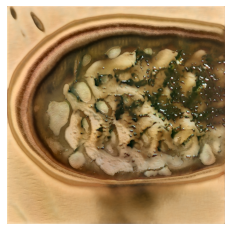

Seed 70001


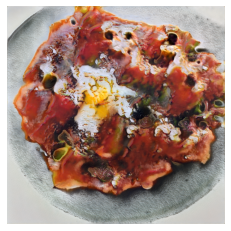

Seed 70002


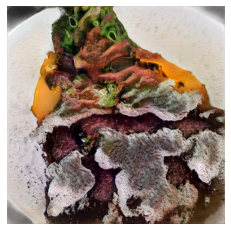

Seed 70003


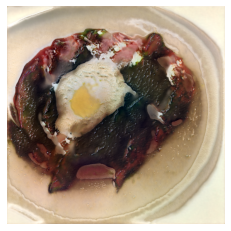

Seed 70004


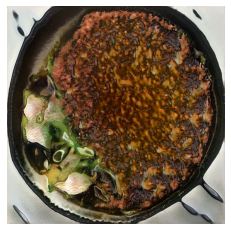

Seed 70005


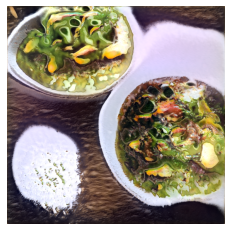

Seed 70006


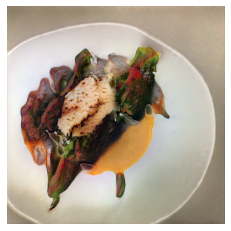

Seed 70007


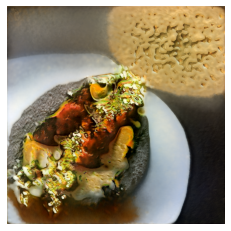

Seed 70008


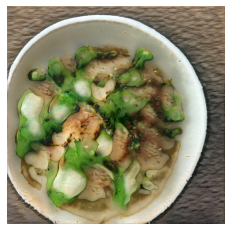

Seed 70009


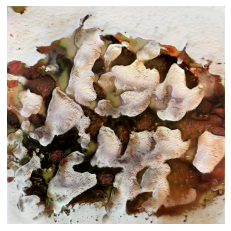

Seed 70010


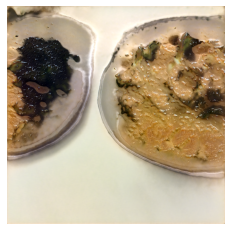

Seed 70011


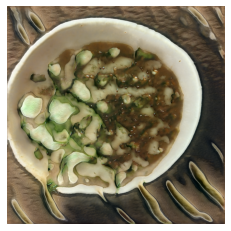

Seed 70012


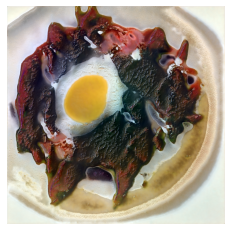

Seed 70013


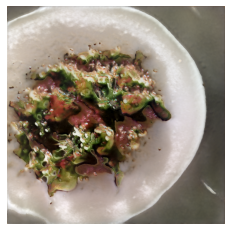

Seed 70014


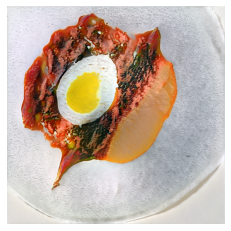

Seed 70015


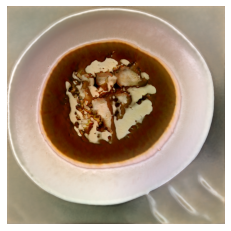

Seed 70016


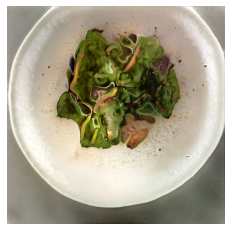

Seed 70017


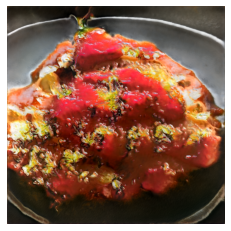

Seed 70018


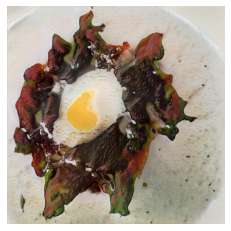

Seed 70019


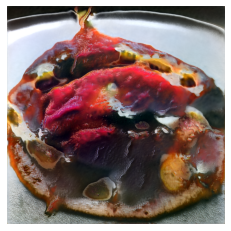

Seed 70020


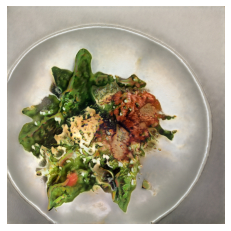

Seed 70021


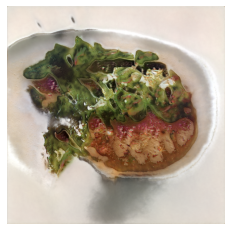

Seed 70022


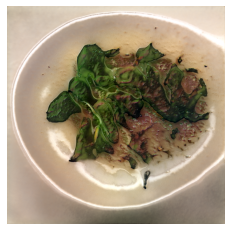

Seed 70023


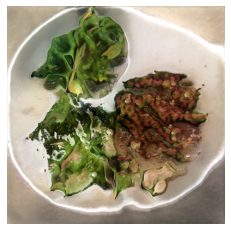

Seed 70024


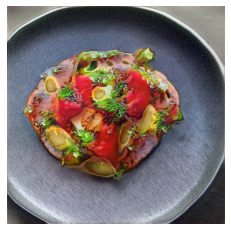

Seed 70025


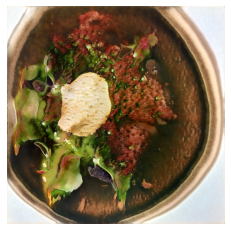

Seed 70026


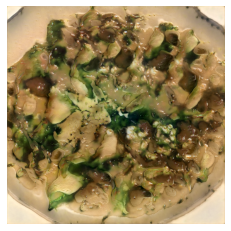

Seed 70027


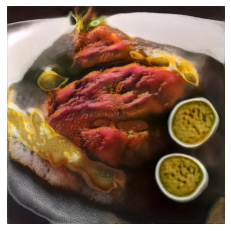

Seed 70028


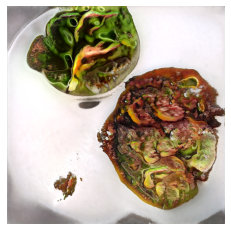

Seed 70029


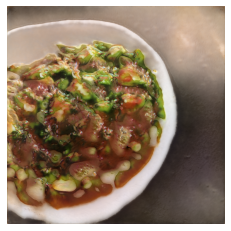

Seed 70030


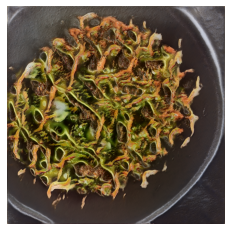

Seed 70031


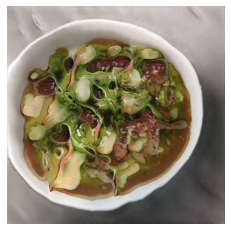

Seed 70032


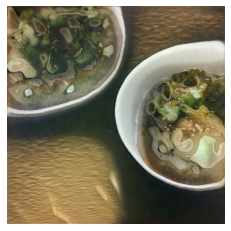

Seed 70033


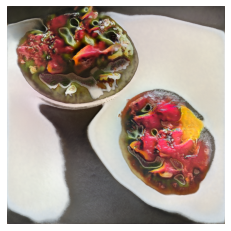

Seed 70034


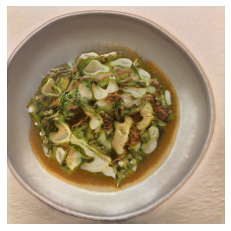

Seed 70035


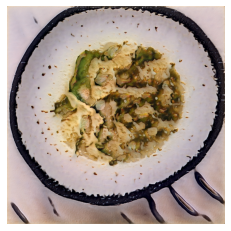

Seed 70036


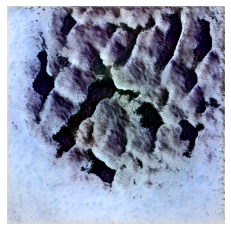

Seed 70037


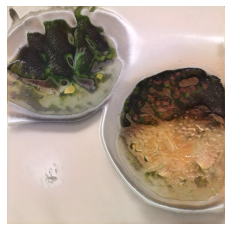

Seed 70038


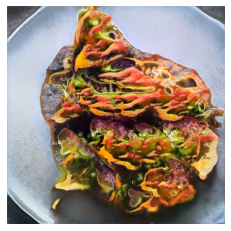

Seed 70039


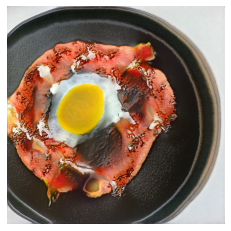

In [ ]:
# Choose starting and ending seed.
SEED_FROM = 70000
SEED_TO = 70040

# Generate the images for the seeds.
for i in range(SEED_FROM, SEED_TO):
  print(f"Seed {i}")
  z = seed2vec(G, i)
  img = generate_image(device, G, z)
  display_image(img)

Preview list of chosen fakes for interpolation video

Seed 8025


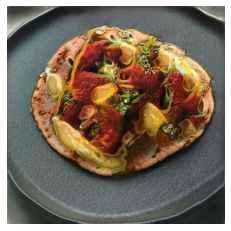

Seed 3006


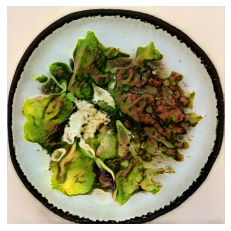

Seed 700


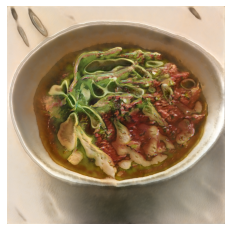

Seed 208


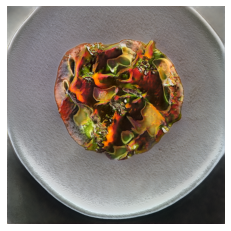

Seed 201


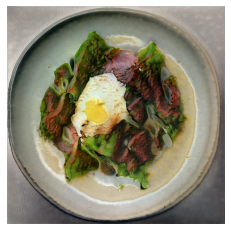

Seed 107


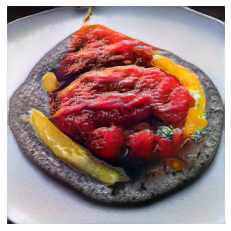

Seed 2018


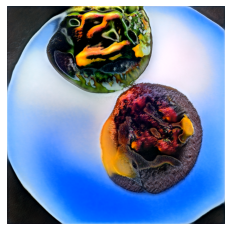

Seed 607


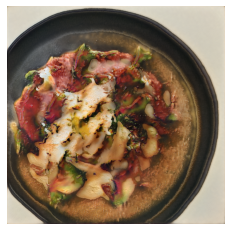

Seed 70024


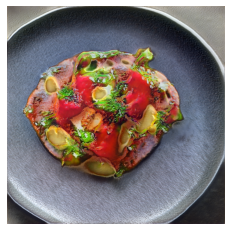

In [ ]:
# Choose list of seeds
SEED_LIST = [8025, 3006, 700, 208, 201, 107, 2018, 607, 70024]

# Generate the images for the seeds.
for i in SEED_LIST:
  print(f"Seed {i}")
  z = seed2vec(G, i)
  img = generate_image(device, G, z)
  display_image(img)

The following code will move between the provided seeds.  The constant STEPS specify how many frames there should be between each of the seeds.

In [ ]:
# Choose your seeds to morph through and the number of steps to take to get to each.

SEEDS = [8025, 3006, 700, 208, 201, 107, 2018, 607, 70024]
STEPS = 100

# Remove any prior results
!rm /content/results/* 

from tqdm.notebook import tqdm

os.makedirs("./results/", exist_ok=True)

# Generate the images for the video.
idx = 0
for i in range(len(SEEDS)-1):
  v1 = seed2vec(G, SEEDS[i])
  v2 = seed2vec(G, SEEDS[i+1])

  diff = v2 - v1
  step = diff / STEPS
  current = v1.copy()

  for j in tqdm(range(STEPS), desc=f"Seed {SEEDS[i]}"):
    current = current + step
    img = generate_image(device, G, current)
    img.save(f'./results/frame-{idx}.png')
    idx+=1
 
# Link the images into a video.
!ffmpeg -r 30 -i /content/results/frame-%d.png -vcodec mpeg4 -y movie.mp4

Seed 8025:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 3006:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 700:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 208:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 201:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 107:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 2018:   0%|          | 0/100 [00:00<?, ?it/s]

Seed 607:   0%|          | 0/100 [00:00<?, ?it/s]

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

Download the generated video.

In [ ]:
from google.colab import files
files.download('movie.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Project Real Images

Upload target images

In [ ]:
import os
from google.colab import files

def upload_files():
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())

In [ ]:
counter = 0
while counter < 3:
  upload_files()
  counter += 1

Saving 1.jpg to 1.jpg


Saving 4.jpg to 4.jpg


Saving 6.jpg to 6.jpg


In [ ]:
NETWORK = "/content/drive/MyDrive/malliGAN/results/00008-food-eheitner1024-mirror-auto1-ada-target0.7-bgc-resumecustom/network-snapshot-000112.pkl"

In [ ]:
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 5000 --outdir=projection_0 --target=1.jpg --network={NETWORK}"
!{cmd}

Streaming output truncated to the last 5000 lines.
step    2/5000: dist 0.66 loss 27640.56
step    3/5000: dist 0.68 loss 27544.63
step    4/5000: dist 0.72 loss 27353.37
step    5/5000: dist 0.72 loss 27069.77
step    6/5000: dist 0.70 loss 26698.15
step    7/5000: dist 0.71 loss 26243.43
step    8/5000: dist 0.69 loss 25711.41
step    9/5000: dist 0.64 loss 25108.93
step   10/5000: dist 0.67 loss 24443.22
step   11/5000: dist 0.73 loss 23720.17
step   12/5000: dist 0.69 loss 22945.03
step   13/5000: dist 0.67 loss 22123.07
step   14/5000: dist 0.74 loss 21259.51
step   15/5000: dist 0.72 loss 20360.19
step   16/5000: dist 0.75 loss 19431.64
step   17/5000: dist 0.69 loss 18480.22
step   18/5000: dist 0.69 loss 17511.74
step   19/5000: dist 0.73 loss 16531.66
step   20/5000: dist 0.67 loss 15545.42
step   21/5000: dist 0.69 loss 14558.09
step   22/5000: dist 0.70 loss 13574.04
step   23/5000: dist 0.67 loss 12597.66
step   24/5000: dist 0.71 loss 11634.39
step   25/5000: dist 0.71 los

In [ ]:
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 5000 --outdir=projection_1 --target=4.jpg --network={NETWORK}"
!{cmd}

Streaming output truncated to the last 5000 lines.
step    2/5000: dist 0.72 loss 27640.62
step    3/5000: dist 0.70 loss 27544.65
step    4/5000: dist 0.69 loss 27353.34
step    5/5000: dist 0.73 loss 27069.79
step    6/5000: dist 0.70 loss 26698.15
step    7/5000: dist 0.67 loss 26243.39
step    8/5000: dist 0.67 loss 25711.38
step    9/5000: dist 0.68 loss 25108.97
step   10/5000: dist 0.71 loss 24443.26
step   11/5000: dist 0.70 loss 23720.14
step   12/5000: dist 0.71 loss 22945.05
step   13/5000: dist 0.70 loss 22123.10
step   14/5000: dist 0.67 loss 21259.45
step   15/5000: dist 0.66 loss 20360.13
step   16/5000: dist 0.73 loss 19431.63
step   17/5000: dist 0.72 loss 18480.25
step   18/5000: dist 0.71 loss 17511.76
step   19/5000: dist 0.72 loss 16531.65
step   20/5000: dist 0.68 loss 15545.43
step   21/5000: dist 0.67 loss 14558.07
step   22/5000: dist 0.69 loss 13574.03
step   23/5000: dist 0.66 loss 12597.65
step   24/5000: dist 0.65 loss 11634.33
step   25/5000: dist 0.73 los

In [ ]:
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 5000 --outdir=projection_2 --target=6.jpg --network={NETWORK}"
!{cmd}

Streaming output truncated to the last 5000 lines.
step    2/5000: dist 0.69 loss 27640.59
step    3/5000: dist 0.72 loss 27544.67
step    4/5000: dist 0.74 loss 27353.39
step    5/5000: dist 0.78 loss 27069.83
step    6/5000: dist 0.72 loss 26698.17
step    7/5000: dist 0.69 loss 26243.40
step    8/5000: dist 0.71 loss 25711.42
step    9/5000: dist 0.72 loss 25109.01
step   10/5000: dist 0.70 loss 24443.26
step   11/5000: dist 0.75 loss 23720.19
step   12/5000: dist 0.75 loss 22945.08
step   13/5000: dist 0.71 loss 22123.11
step   14/5000: dist 0.70 loss 21259.48
step   15/5000: dist 0.69 loss 20360.16
step   16/5000: dist 0.69 loss 19431.58
step   17/5000: dist 0.72 loss 18480.25
step   18/5000: dist 0.75 loss 17511.80
step   19/5000: dist 0.70 loss 16531.63
step   20/5000: dist 0.70 loss 15545.45
step   21/5000: dist 0.70 loss 14558.10
step   22/5000: dist 0.73 loss 13574.07
step   23/5000: dist 0.69 loss 12597.67
step   24/5000: dist 0.73 loss 11634.41
step   25/5000: dist 0.74 los

Examine GAN projections against target images

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import cv2

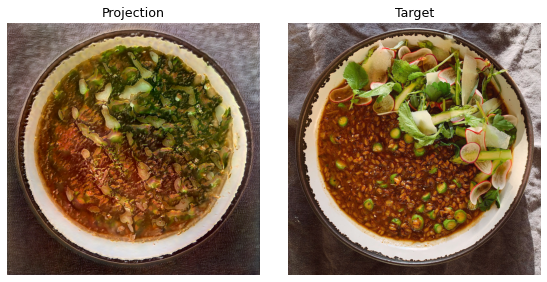

In [ ]:
# Projection 0

sns.set_context('talk', font_scale=0.7)

img_gan_source1 = cv2.imread('/content/projection_0/proj.png')
img_gan_source2 = cv2.imread('/content/projection_0/target.png')
img1, img2 = cv2.cvtColor(img_gan_source1, cv2.COLOR_BGR2RGB), cv2.cvtColor(img_gan_source2, cv2.COLOR_BGR2RGB)

fig, axarr = plt.subplots(1,2, figsize=(8,4))
axarr[0].imshow(img1)
axarr[0].set_title('Projection')
axarr[0].axis('off')
axarr[1].imshow(img2)
axarr[1].set_title('Target')
axarr[1].axis('off')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/malliGAN/malli-projection-0.png');

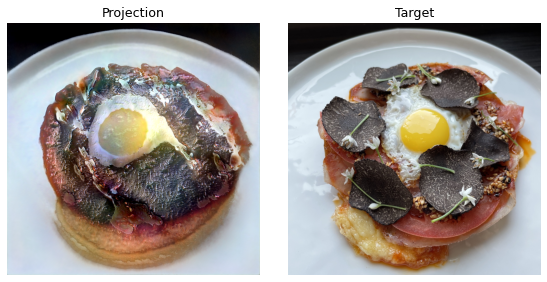

In [ ]:
# Projection 1
img_gan_source1 = cv2.imread('/content/projection_1/proj.png')
img_gan_source2 = cv2.imread('/content/projection_1/target.png')
img1, img2 = cv2.cvtColor(img_gan_source1, cv2.COLOR_BGR2RGB), cv2.cvtColor(img_gan_source2, cv2.COLOR_BGR2RGB)

fig, axarr = plt.subplots(1,2, figsize=(8,4))
axarr[0].imshow(img1)
axarr[0].set_title('Projection')
axarr[0].axis('off')
axarr[1].imshow(img2)
axarr[1].set_title('Target')
axarr[1].axis('off')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/malliGAN/malli-projection-1.png');

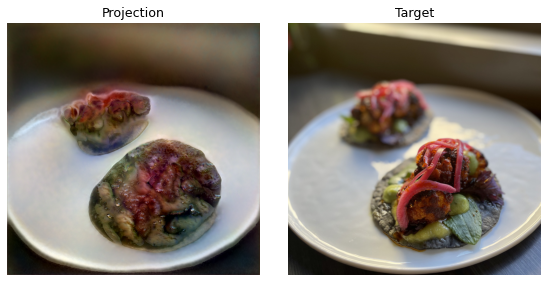

In [ ]:
# Projection 2
img_gan_source1 = cv2.imread('/content/projection_2/proj.png')
img_gan_source2 = cv2.imread('/content/projection_2/target.png')
img1, img2 = cv2.cvtColor(img_gan_source1, cv2.COLOR_BGR2RGB), cv2.cvtColor(img_gan_source2, cv2.COLOR_BGR2RGB)

fig, axarr = plt.subplots(1,2, figsize=(8,4))
axarr[0].imshow(img1)
axarr[0].set_title('Projection')
axarr[0].axis('off')
axarr[1].imshow(img2)
axarr[1].set_title('Target')
axarr[1].axis('off')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/malliGAN/malli-projection-2.png');